In [3]:
from io import BytesIO
from typing import List

import numpy as np
import scipy.signal
from IPython import display
from PIL import Image, ImageDraw

from main import dataloader, to_vect, Coordinates
import matplotlib.pyplot as plt


In [4]:
sample = next(iter(dataloader))
session = sample["patchy"]
ZOOM_FACTOR = 3.0

def transform(coords: List[Coordinates], offset: np.ndarray, factor: float) -> np.ndarray:
    return (to_vect(coords) + offset) * factor
mushrooms_coords = transform(session.mushroom_coords, np.array([200, 0, 200]), ZOOM_FACTOR)
mushrooms_coords = mushrooms_coords[:,[0,2]]
player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
player_coords = player_coords[:,[0,2]]
max_coord_x = int(mushrooms_coords[:,0].max())
max_coord_z = int(mushrooms_coords[:,1].max())

In [5]:
player_coords_deriv = player_coords[1:] - player_coords[:-1]
player_dist = np.linalg.norm(player_coords_deriv, axis=1)
print(player_coords_deriv.shape, player_dist.shape)

(29999, 2) (29999,)


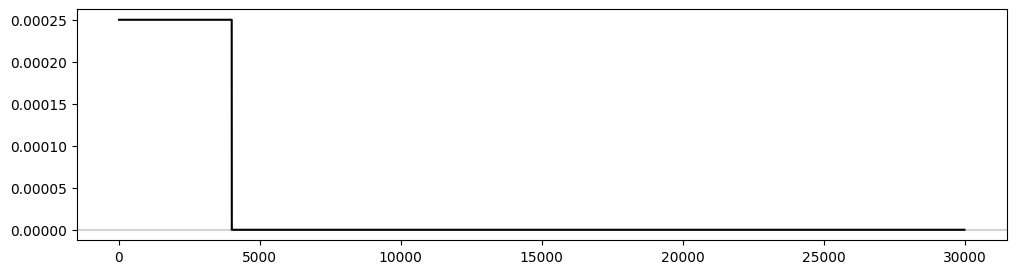

In [6]:
def make_window_average_filter(size, delta_t):
    window = np.zeros(size)
    window[:delta_t] = 1 / delta_t
    return window

plt.figure(figsize=(12, 3))
plt.axhline(y=0, color='lightgray')
plt.plot(make_window_average_filter(player_coords_deriv.shape[0], 4000), color='k')
plt.show()

(28999,)


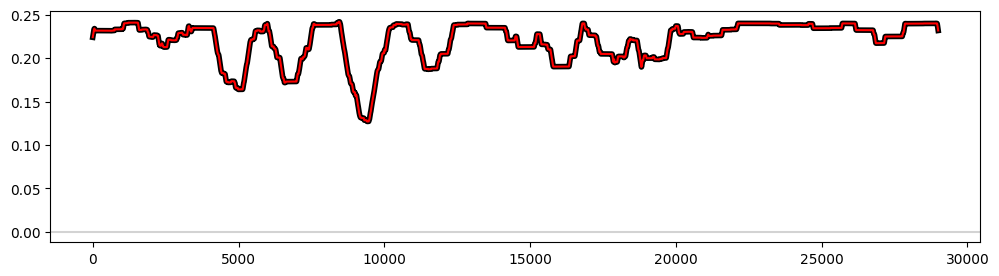

In [7]:
delta_t = 1000
window_average_filter = make_window_average_filter(player_dist.shape[0], delta_t)

def convolve(x, window):
    y = scipy.signal.fftconvolve(x, window, axes=0)[delta_t:x.shape[0]]
    return y

player_dist_deltat = convolve(player_dist, window_average_filter)
player_dist_hand = [np.mean(player_dist[t:t+delta_t]) for t in range(player_dist.shape[0]-delta_t+1)]
print(player_dist_deltat.shape)

plt.figure(figsize=(12, 3))
plt.axhline(y=0, color='lightgray')
plt.plot(player_dist_hand, color='k', linewidth=4)
plt.plot(player_dist_deltat, color='r')
plt.show()

In [13]:
player_deriv_deltat = convolve(player_coords_deriv, window_average_filter[:, None])
player_bird_distance_deltat = np.linalg.norm(player_deriv_deltat, axis=1)
player_deriv_deltat

array([[ 0.12047298,  0.07602846],
       [ 0.12064156,  0.07619925],
       [ 0.12081235,  0.07636789],
       ...,
       [-0.07466   , -0.18757235],
       [-0.07453191, -0.18737869],
       [-0.07441949, -0.18717677]])

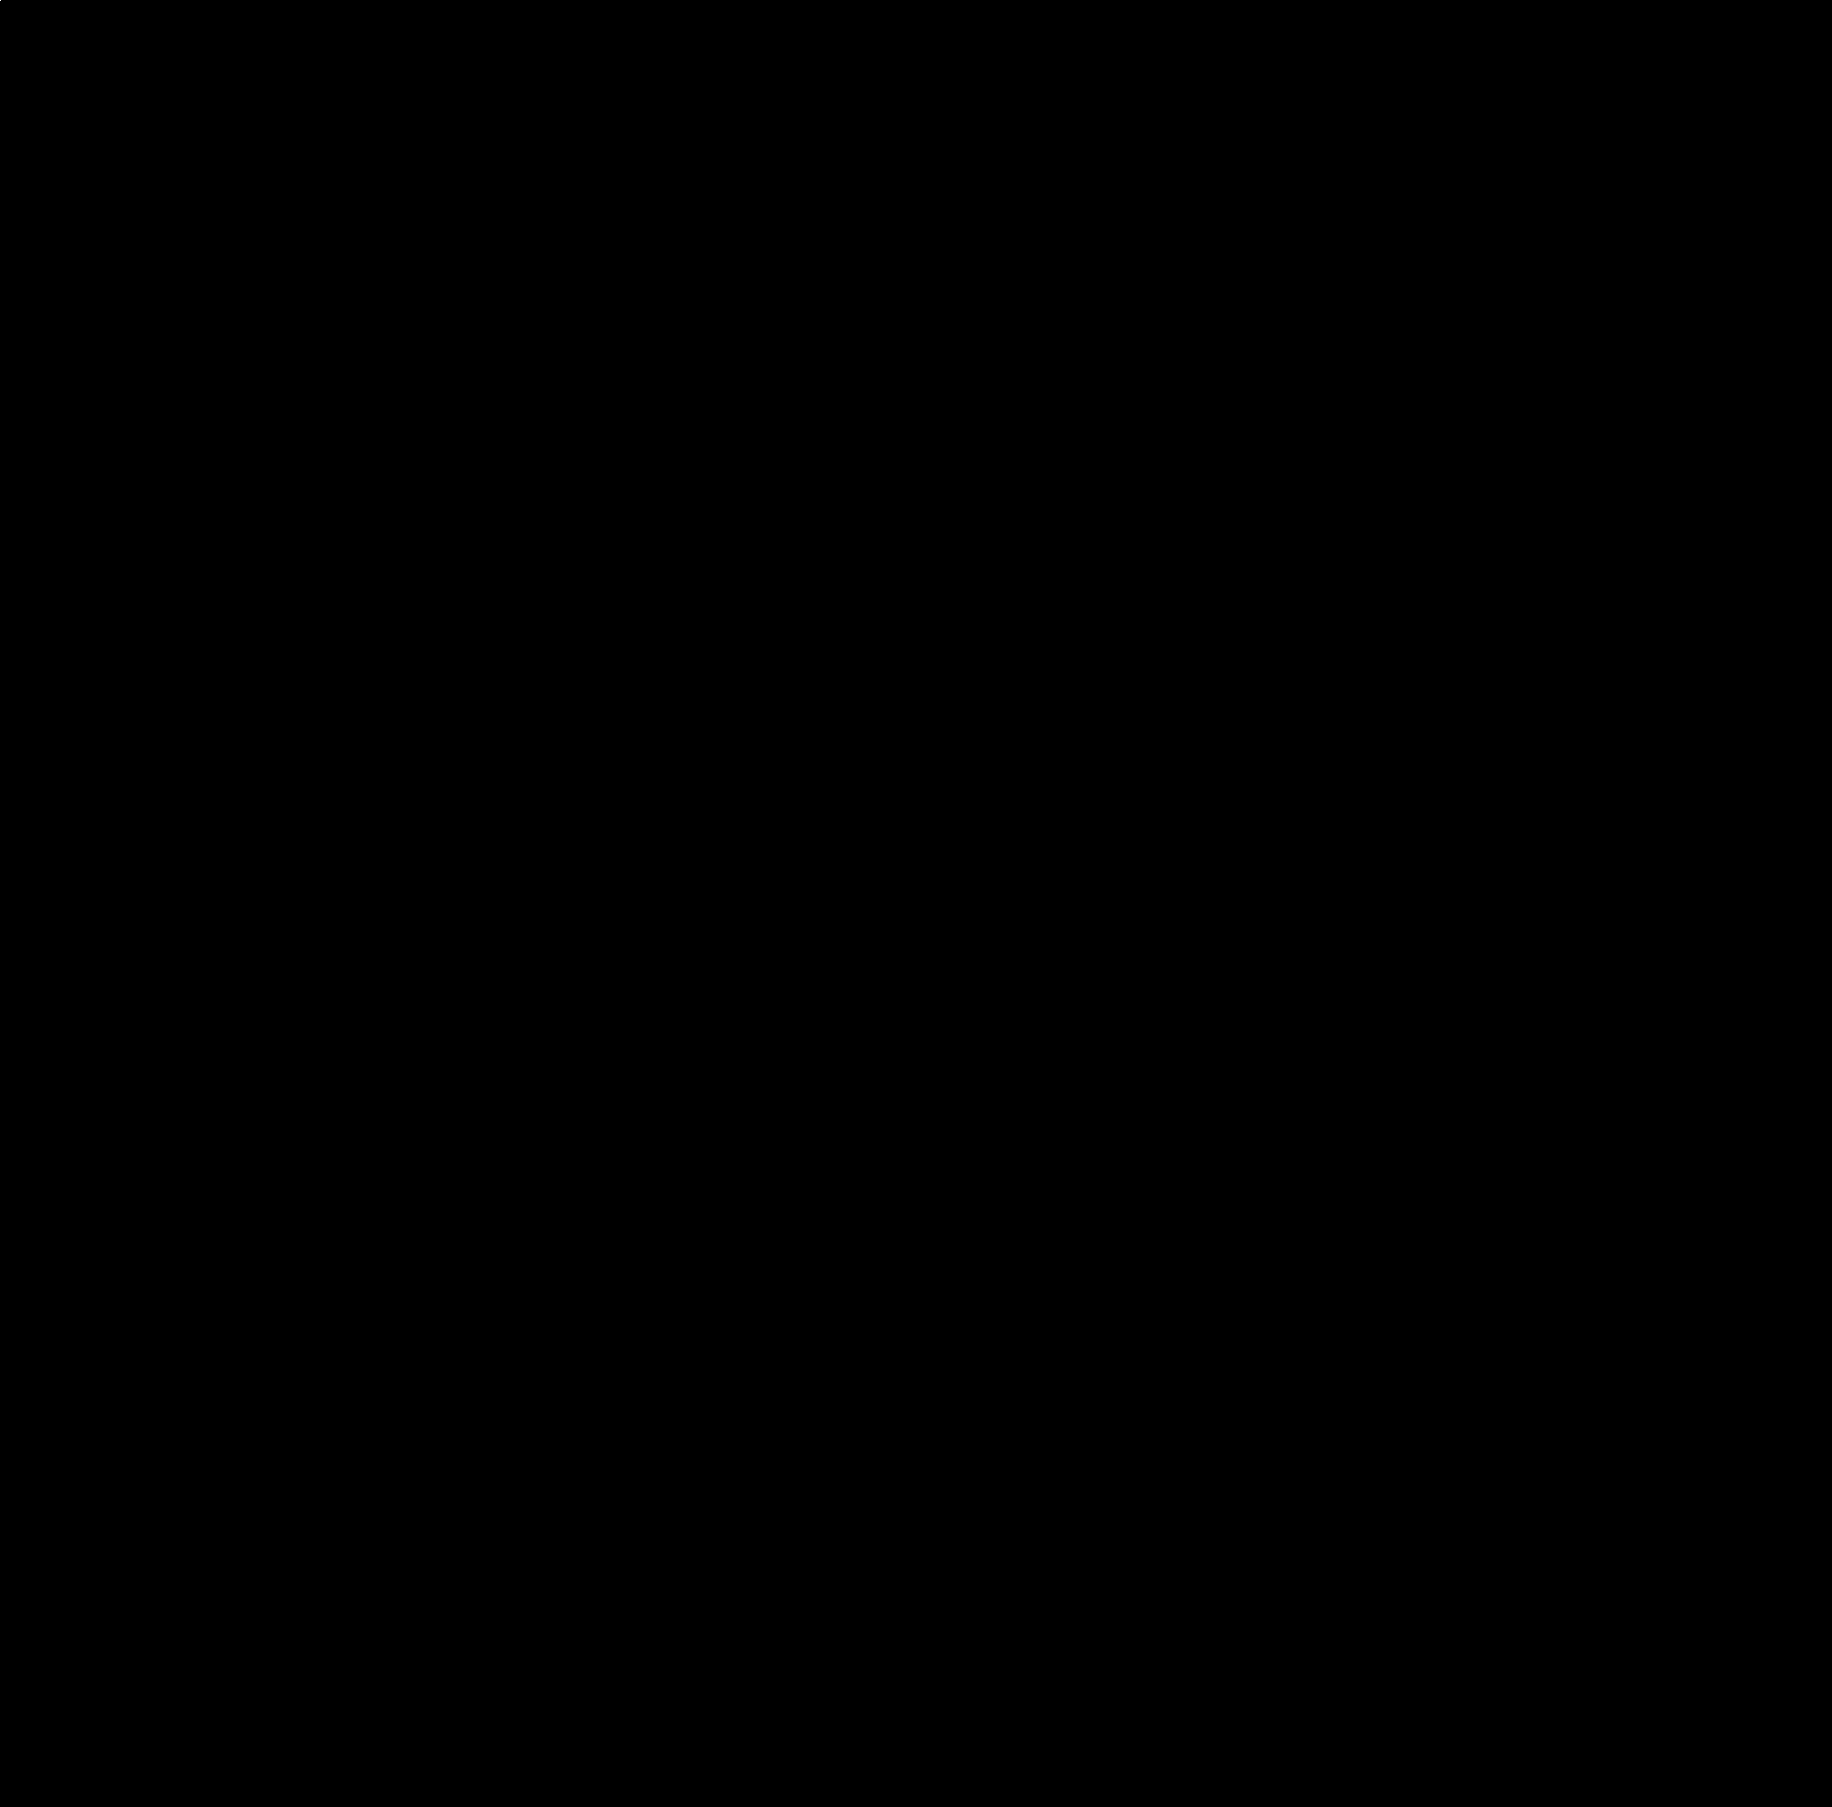

In [11]:
with Image.new(mode="1", size=(max_coord_x, max_coord_z)) as im:
    draw = ImageDraw.Draw(im)
    draw.line([tuple(p) for p in player_deriv_deltat.astype(int)],fill=1, width=5)
    display.display(im)
    

In [ ]:
# feature_deltat = np.mean(player_dist_deltat / player_bird_distance_deltat)
# print(feature_deltat)

def make_window_average_filter(size, delta_t):
    window = np.zeros(size)
    window[:delta_t] = 1 / delta_t
    return window

def convolve(x, window, delta_t):
    y = scipy.signal.fftconvolve(x, window, axes=0)[delta_t:x.shape[0]]
    return y

def compute_feature_deltat(player_coords, delta_t):
    player_coords_deriv = player_coords[1:] - player_coords[:-1]
    player_dist = np.linalg.norm(player_coords_deriv, axis=1)
    
    window_average_filter = make_window_average_filter(player_dist.shape[0], delta_t)
    player_dist_deltat = convolve(player_dist, window_average_filter, delta_t)
    player_deriv_deltat = convolve(player_coords_deriv, window_average_filter[:, None], delta_t)
    player_bird_distance_deltat = np.linalg.norm(player_deriv_deltat, axis=1)
    # removing 0 values to prevent NaN
    zero_indexes = player_bird_distance_deltat != 0
    player_bird_distance_deltat = player_bird_distance_deltat[zero_indexes]
    player_dist_deltat = player_dist_deltat[zero_indexes]
    feature_deltat = np.mean(player_dist_deltat / player_bird_distance_deltat)
    return feature_deltat

deltats = [2**i for i in range(14)]
features = [compute_feature_deltat(player_coords, delta_t) for delta_t in deltats]

plt.figure(figsize=(12, 3))
plt.axhline(y=0, color='lightgray')
plt.plot(deltats, features, color='k')
plt.scatter(deltats, features, color='b', alpha=0.5)
plt.xscale('log')
#plt.show()
plot_buff = BytesIO()
plt.savefig(plot_buff)
plot_buff.seek(0)
plot_img = Image.open(plot_buff)
#plot_img

In [ ]:
plt.plot(player_bird_distance_deltat, label="bird distance")
plt.plot(player_dist_deltat, label="distance ")
plt.legend()
plt.show()

In [ ]:
def upscale(img: Image, factor: float) -> Image:
    new_size = tuple((np.array(img.size) * factor).astype(int))
    return img.resize(new_size)
upscaled_plot_img = upscale(plot_img, im.size[0] / plot_img.size[0])
stacked = Image.new("RGB", (im.width, upscaled_plot_img.width + im.width))
stacked.paste(upscaled_plot_img, (0,0))
stacked.paste(im, (0, upscaled_plot_img.height))
stacked